In [9]:
import socket
import time
import struct
import threading
import numpy as np
import matplotlib.pyplot as plt
 
class MotionCompensationSimulator:
    def __init__(self, trace_file, latency=1.0,
                 local_ip="0.0.0.0", local_port=2400, target_ip="192.168.8.2", target_port=1400,
                 log_file="simulation_log.txt"):
 
        # Load input trace file: assumed to have [timestamp, y_position] per line
        self.timestamps = []
        self.true_motion = []
        with open(trace_file, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 2:
                    self.timestamps.append(float(parts[0]))
                    self.true_motion.append(float(parts[1]))
 
        self.timestamps = np.array(self.timestamps)
        self.true_motion = np.array(self.true_motion)
 
        # Simulation parameters
        self.latency = latency  # In seconds
 
        # Networking
        self.local_ip = local_ip
        self.local_port = local_port
        self.target_ip = target_ip
        self.target_port = target_port
 
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        self.sock.bind((self.local_ip, self.local_port))
        self.sock.settimeout(1.0)
 
        # Logging
        self.log_file_path = log_file
        self.log_lines = []
 
        # Shared feedback state
        self.feedback_total = 0.0
        self.feedback_lock = threading.Lock()
        self.stop_flag = threading.Event()
 
    def feedback_listener(self):
        while not self.stop_flag.is_set():
            try:
                data, addr = self.sock.recvfrom(1024)
                if len(data) >= 8:
                    feedback_val = struct.unpack("d", data[:8])[0]
                    with self.feedback_lock:
                        self.feedback_total += feedback_val
            except socket.timeout:
                continue
 
    def sender(self):
        start_time = time.time()
        for i, t in enumerate(self.timestamps):
            while time.time() < start_time + t + self.latency:
                time.sleep(0.001)
 
            with self.feedback_lock:
                corrected_y = self.true_motion[i] + self.feedback_total
 
            packed = struct.pack("d", corrected_y)
            self.sock.sendto(packed, (self.target_ip, self.target_port))
 
            self.log_lines.append(f"{t:.5f}\t{self.true_motion[i]:.4f}\t{corrected_y:.4f}\t{corrected_y:.4f}")
 
        self.stop_flag.set()
 
    def run_simulation(self):
        recv_thread = threading.Thread(target=self.feedback_listener, daemon=True)
        send_thread = threading.Thread(target=self.sender)
 
        recv_thread.start()
        send_thread.start()
 
        send_thread.join()
        recv_thread.join(timeout=2.0)
 
        self.sock.close()
        with open(self.log_file_path, "w") as f:
            f.write("Time\tTrueY\tSentY\tCorrectedY\n")
            f.write("\n".join(self.log_lines))
 
    def plot_results(self):
        time_vals, true_y, sent_y, corrected_y = [], [], [], []
 
        with open(self.log_file_path, "r") as f:
            next(f)  # skip header
            for line in f:
                t, ty, sy, cy = map(float, line.strip().split())
                time_vals.append(t)
                true_y.append(ty)
                sent_y.append(sy)
                corrected_y.append(cy)
 
        residual_error = [ty - cy for ty, cy in zip(true_y, corrected_y)]
 
        plt.figure(figsize=(10, 6))
        plt.plot(time_vals, true_y, label="Input Motion")
        plt.plot(time_vals, sent_y, label="Sent Signal",linestyle='--')
        plt.plot(time_vals, corrected_y, label="Compensated motion")
        #plt.plot(time_vals, residual_error, label="Residual Error", linestyle='--')
        plt.xlabel("Time (s)")
        plt.ylabel("Position (mm)")
        plt.title(f"Sine 15s 10mm Motion Compensation with {self.latency:.1f}s Tracking Latency")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
 
        print(f"Max Error: {max(abs(e) for e in corrected_y):.2f} mm")
        print(f"RMS Error: {np.sqrt(np.mean(np.square(residual_error))):.2f} mm")

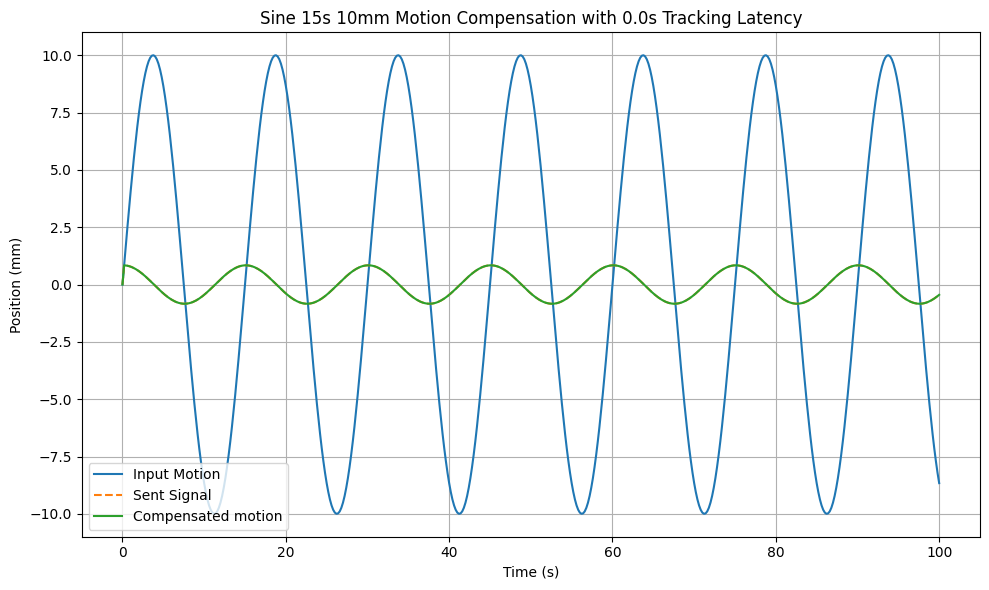

Max Error: 0.84 mm
RMS Error: 7.02 mm


In [10]:
sim = MotionCompensationSimulator(trace_file="C:\\Users\\imagex_labl\\Downloads\\sine_wave_data_15s.txt", latency=0)
sim.run_simulation()
sim.plot_results()